In [215]:
import torch

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import random_split
from torch.nn import CrossEntropyLoss

from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset, BAShapes
from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.pool import global_mean_pool, global_max_pool
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ExplainerConfig, ThresholdConfig

In [216]:
dataset = TUDataset(root='data/', name='MUTAG', use_node_attr=True)
data_train, data_test = random_split(dataset, [0.8, 0.2])

loader_train = DataLoader(data_train, batch_size=8, shuffle=True)
loader_test = DataLoader(data_test, batch_size=8, shuffle=True)

In [217]:
class GCN(torch.nn.Module):
    def __init__(self, nhidden):
        super().__init__()
        self.nhidden = nhidden
        self.conv1 = GCNConv(7, 16)
        self.conv2 = GCNConv(16, 2)
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = global_max_pool(x, batch=batch)

        return F.log_softmax(x, dim=1)

In [218]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [219]:
cross_entropy_loss = CrossEntropyLoss()

def train_epoch():
    train_losses = []
    for train_batch in loader_train:
        model.train()
        optimizer.zero_grad()
        out = model(train_batch.x, train_batch.edge_index, train_batch.batch)
        loss = cross_entropy_loss(out, train_batch.y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

In [220]:
def bin_accuracy(pred, ground, thresh):
    k = 0
    assert(len(pred) == len(ground))
    for i in range(len(pred)):
        k+= int(int(pred[i][0] > thresh) == ground[i])
    return k/len(pred)

In [221]:
for epoch in range(0,101):
    train_loss = train_epoch()
    if(epoch % 5 == 0):
        test_losses = []
        test_accuracy = []
        for test_batch in loader_test:
            out = model(test_batch.x, test_batch.edge_index, test_batch.batch)
            test_losses.append(cross_entropy_loss(out, test_batch.y).item())
            test_accuracy.append(bin_accuracy(out, test_batch.y, 0.5))

        print(f"Epoch {epoch} : Train {train_loss.round(2)}, Test {np.mean(test_losses).round(2)}, Accuracy {np.mean(test_accuracy).round(2)}")

Epoch 0 : Train 0.62, Test 0.62, Accuracy 0.34
Epoch 5 : Train 0.58, Test 0.59, Accuracy 0.36
Epoch 10 : Train 0.55, Test 0.59, Accuracy 0.36
Epoch 15 : Train 0.58, Test 0.59, Accuracy 0.34
Epoch 20 : Train 0.56, Test 0.55, Accuracy 0.32
Epoch 25 : Train 0.54, Test 0.61, Accuracy 0.34
Epoch 30 : Train 0.55, Test 0.6, Accuracy 0.37
Epoch 35 : Train 0.57, Test 0.61, Accuracy 0.36
Epoch 40 : Train 0.54, Test 0.56, Accuracy 0.32
Epoch 45 : Train 0.56, Test 0.62, Accuracy 0.38
Epoch 50 : Train 0.53, Test 0.6, Accuracy 0.34
Epoch 55 : Train 0.56, Test 0.59, Accuracy 0.34
Epoch 60 : Train 0.54, Test 0.59, Accuracy 0.34
Epoch 65 : Train 0.57, Test 0.63, Accuracy 0.36
Epoch 70 : Train 0.56, Test 0.66, Accuracy 0.34
Epoch 75 : Train 0.56, Test 0.65, Accuracy 0.37
Epoch 80 : Train 0.55, Test 0.59, Accuracy 0.34
Epoch 85 : Train 0.57, Test 0.63, Accuracy 0.34
Epoch 90 : Train 0.56, Test 0.62, Accuracy 0.36
Epoch 95 : Train 0.55, Test 0.57, Accuracy 0.34
Epoch 100 : Train 0.55, Test 0.66, Accuracy 

In [226]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explainer_config=ExplainerConfig(
        explanation_type='model',
        node_mask_type='object',
        edge_mask_type='object'
    ),
    model_config=dict(
        mode='classification',
        task_level='graph',
        return_type='probs'
        ),
     threshold_config=ThresholdConfig('hard', 0.1)
    )

In [227]:
sample = data_test[9]


args = {'batch' : torch.Tensor([int(0) for i in range(len(sample.x))],).long()}

e = explainer(sample.x, sample.edge_index, **args)

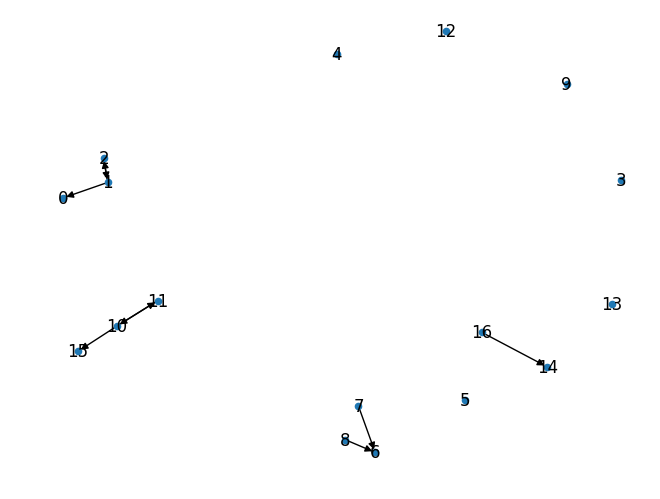

In [241]:
nx.draw(to_networkx(e.get_explanation_subgraph()), node_size=20, with_labels=True)


In [237]:
print(e.node_mask)
print(e.edge_mask)
for i, m in enumerate(e.edge_mask):
    if m == 1.0:
        print(f"{sample.edge_index[0][i]} -> {sample.edge_index[1][i]}")

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])
1 -> 0
1 -> 2
2 -> 1
7 -> 6
8 -> 6
10 -> 11
10 -> 15
11 -> 10
16 -> 14
